In [ ]:
import pathlib
import seaborn as sns
import utils
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt

url = 'https://glusfqycvwrucp9-db202202211424.adb.eu-zurich-1.oraclecloudapps.com/ords/sensor_datalake1/sens/insert/'

page_result = utils.get_all_pages(url)

df = utils.to_data_frame(page_result)

In [ ]:
df

In [ ]:
#convert inser_time to timedate
df['insert_time'] = pd.to_datetime(df['insert_time'])
#and add 2 hours to insert time
df['insert_time'] = df['insert_time'] + pd.Timedelta(hours=2)

df.info()

In [ ]:
#pivot
df_pivot = df.pivot_table(index='insert_time',columns=['sensor_id','unit1'],values='value1')
#multindex to single index
df_pivot.columns =	df_pivot.columns.map('_'.join)
#resample on 5min time windows

df_pivot = df_pivot.resample('5Min').agg({'CIRCUITPY323d_PPM':'mean', 'CIRCUITPY323d_C':'mean','CIRCUITPY323d_%':'mean','CIRCUITPY323d_%':'mean','CIRCUITPY825a_Window':'last','CIRCUITPYbec9_Person':'last'})
df_pivot.head(30)

In [ ]:
#neue Variable die die Luftqualität Quantitativ einordnet
df_pivot["air_quality"] = 0
for i in range(len(df_pivot)):
    if df_pivot["CIRCUITPY323d_PPM"][i] <= 800:
        df_pivot["air_quality"] = "top"
    elif 800 < df_pivot["CIRCUITPY323d_PPM"][i] <= 1000:
        df_pivot["air_quality"] = "high"
    elif 1000 < df_pivot["CIRCUITPY323d_PPM"][i] <= 1400:
        df_pivot["air_quality"] = "medium"
    elif 1400 < df_pivot["CIRCUITPY323d_PPM"][i]:
        df_pivot["air_quality"] = "low"

In [ ]:
#select specific time window
df_timewindow = df_pivot.loc['2022-03-30 12:30:00':'2022-04-26 7:54:00']

In [ ]:
#Fill Nan for window sensor
df_timewindow['CIRCUITPY825a_Window'].fillna(method='ffill',inplace=True)
df_timewindow['CIRCUITPY825a_Window'].fillna(method='bfill',inplace=True)
#Fill Nan for people sensor
df_timewindow['CIRCUITPYbec9_Person'].fillna(method='ffill',inplace=True)
#Fill Nan for first entry for people sensor
df_timewindow['CIRCUITPYbec9_Person'].fillna(method='bfill',inplace=True)

df_timewindow.head(5)

In [ ]:
#linechart cobined with bar chart
#if windows sensor 1 blue line if windows sensor 0 red line
# Use a boundary norm instead
fig, ax1 = plt.subplots()
#hide grid
ax1 = df_timewindow['CIRCUITPY323d_PPM'].plot(kind='line',color='blue',label='PPM', grid=False)
ax3 = ax1.twinx()
ax3 = df_timewindow['CIRCUITPY323d_C'].plot(kind='line',color='red',label='C', grid=False,ylim=(0,30))
ax4 = ax1.twinx()
ax4 = df_timewindow['CIRCUITPY323d_%'].plot(kind='line',color='green',label='%', grid=False,ylim=(20,60))
ax2 = ax1.twinx()
ax2 = df_timewindow['CIRCUITPYbec9_Person'].plot(kind='line',color='red',label='People Count',ylim=(0,5))
ax1.pcolorfast(ax1.get_xlim(), ax1.get_ylim(),df_timewindow['CIRCUITPY825a_Window'].values[np.newaxis],cmap='RdYlGn', alpha=0.3,label='Windows')
#set size
ax1.figure.set_size_inches(20, 5)
#show legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax3.legend(loc='center right')
ax4.legend(loc='lower right')
#additonal legend for window sensor


plt.show()

In [ ]:
#calculate correleation between two columns
df_timewindow.corr()

Janis Ideen data wrangling

In [33]:
df_pivot.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9511 entries, 2022-03-24 16:00:00+00:00 to 2022-04-26 16:30:00+00:00
Freq: 5T
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CIRCUITPY323d_PPM     6128 non-null   float64
 1   CIRCUITPY323d_C       6127 non-null   float64
 2   CIRCUITPY323d_%       6125 non-null   float64
 3   CIRCUITPY825a_Window  7734 non-null   float64
 4   CIRCUITPYbec9_Person  7733 non-null   float64
dtypes: float64(5)
memory usage: 703.9 KB


/Users/janisfrolich/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/janisfrolich/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/janisfrolich/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpr

<AxesSubplot:xlabel='CIRCUITPYbec9_Person'>

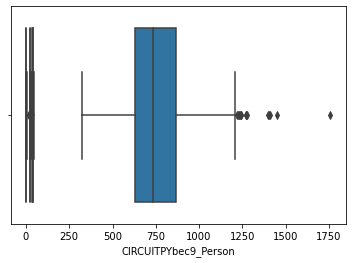

In [21]:
#detect outliers in PPM data
#print boxlot
utils.overview(df_pivot, "CIRCUITPY323d_PPM")
utils.overview(df_pivot, "CIRCUITPY323d_C")
utils.overview(df_pivot, "CIRCUITPY323d_%")
utils.overview(df_pivot, "CIRCUITPYbec9_Person")

In [ ]:
print(df_timewindow['CIRCUITPY323d_PPM'].max())
print(df_timewindow['CIRCUITPY323d_PPM'].min())